# Lesson: Distributions

## Our A/B testing model
```python
with pymc.Model():
    # parameter we want to infer with prior
    conversion_rate = pymc.Beta("conversion_rate", 2, 10)
    # likelihood of observing data given parameter
    likelihood = pymc.Bernoulli("likelihood", 
                                p=conversion_rate, 
                                observed=conversions)
```

You've now seen the A/B testing model a couple of times and even used it yourself in the last lesson. In this lesson we're going to break it apart into its smallest pieces. Why are we doing this? In the first lesson we talked about how Bayesian Models are like Lego. We handed you a complete Lego in the first three lessons with A/B test model. By showing you how its built you'll be better prepared to then use that knowledge to build more complex models, such as the ones in later lessons.

## Distributions are the building blocks

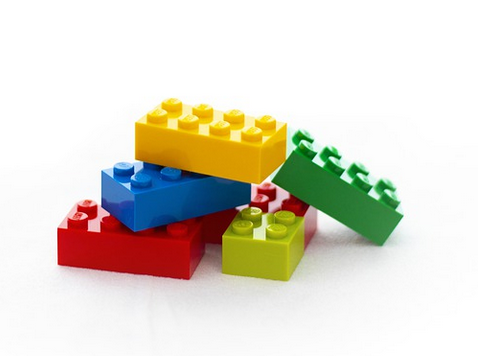

That small piece is the is a distribution.  

We'll why and what they are in this lesson, as well as some of the amazing properties such as Probability Mass and Distribution functions, and computation sampling. These ideas are core to Bayesian modeling and understanding them give you a great intuition as to what's happening under the hood of PyMC.

Let's jump in!

### Distributions and Uncertainty

* How distributions formalize uncertainty
* Why we'll focus on computational specification
* How distributions are central to Bayes Theorem

### Distribution Parameters
* What distribution parameters are
* How they define the shape of a distribution
* That there are differing naming conventions

### Two Types of Samples
* The two types of samples that enable modern Bayesian inference 
  * Observed samples of your data
  * Samples from computational distributions
* What each does to enable inference

### PMF and PDF
* How to compare relative beliefs using Probability Density and Probability Mass functions
* How to calculate PDF and PMF
* Why this is important in a Bayesian context

# Why distributions

Why distributions are a fundamental tool in summarizing observations, parameters, and uncertainty

In [21]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.ticker as mtick

In [3]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)

# Revisiting our A/B test

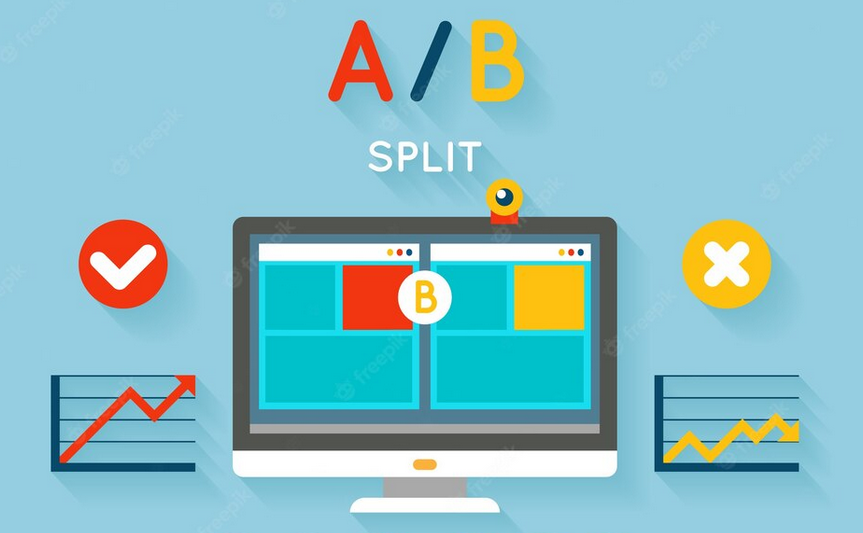

<a href="https://www.freepik.com/vectors/people">People vector created by macrovector - www.freepik.com</a>

Let's revisit our A/B test. Remember why we're doing this. We want estimate if Website A or Website B has a better conversion rate. Regardless of what estimation technique we use we'll need data.

In [4]:
# If reading this outside of the video I'm saving the data locally as we don't cover 
# sampling until a later section!
np.random.seed(RANDOM_SEED)
b = stats.bernoulli(p=.15)
b_observations = b.rvs(100)
np.savetxt("b_observations.txt", b_observations)

In [5]:
#TODO; Update to match tools lessons
b_observations = np.loadtxt("b_observations.txt")
b_observations 

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [7]:
b_observations.shape

(100,)

Here it is, for now let's just focus on website B. We want to estimate what the probability is someone will convert on website B. We can our observed data to form an estimate.

# Calculating our conversion rate the naive way
Taking the mean

In [9]:
numerator = b_observations.sum()
denominator = b_observations.shape[0]
numerator/denominator

0.1

The easiest way to do it is to take the average which gets us an answer of 10%, But how sure we exactly .1 or 10%, why couldn't it 9.9% or 10.1%, or even 5% or 99%?


## How sure are about our parameter estimate, `p(conversion)`?

Let's run an experiment.

What if we observed _just the first **10** people_ instead of 100? 

In [9]:
b_observations[:10].mean()

0.2

# 🤔

Let's use our same array. What we only had time to observe the first 10 visitors? Now our conversion rate would be 20% instead of 10%. 

Well this is weird, with 100 observations we got 10%, but now we have 20%? Which number is correct?

## What if we just had one observation, what would `p(conversion)` be?
Let's take this to the extreme. 

What if we just had one observation?

In [10]:
b_observations[0].mean()

0.0

# 🤯

0% conversion? Was our experiment a total failure?

But with only one observation do we really feel certain about our estimate of p?

## Point estimates don't convey uncertainty


/tmp/ipykernel_30036/2348395565.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(i,y ,'ro', c='b')


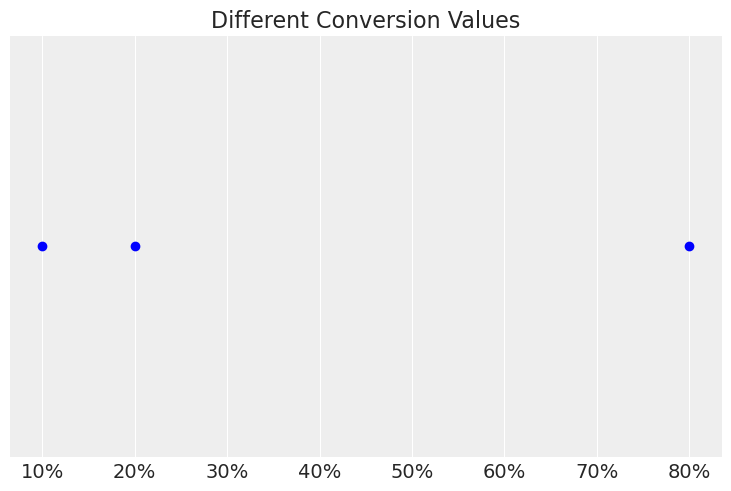

In [23]:
fig, ax = plt.subplots()
y = 1
x = [20, 10, 80]

for i in x:
    ax.plot(i,y ,'ro', c='b')

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title("Different Conversion Values")
ax.set_yticks([]);


Point estimates don't convey uncertainty! Whether the mean was calculated with 1 observation, or 10 observations, or a 100


The truth is we might never know the exact conversion ratio, but we do know that a single number doesn't adequately communicate our confidence in our belief in P.

Using a single number point estimate like 10%, 20%, or 0% doesn't tell the full story.

## Communicating uncertainty with distributions
The distribution conveys our belief in *every possible conversion value*.

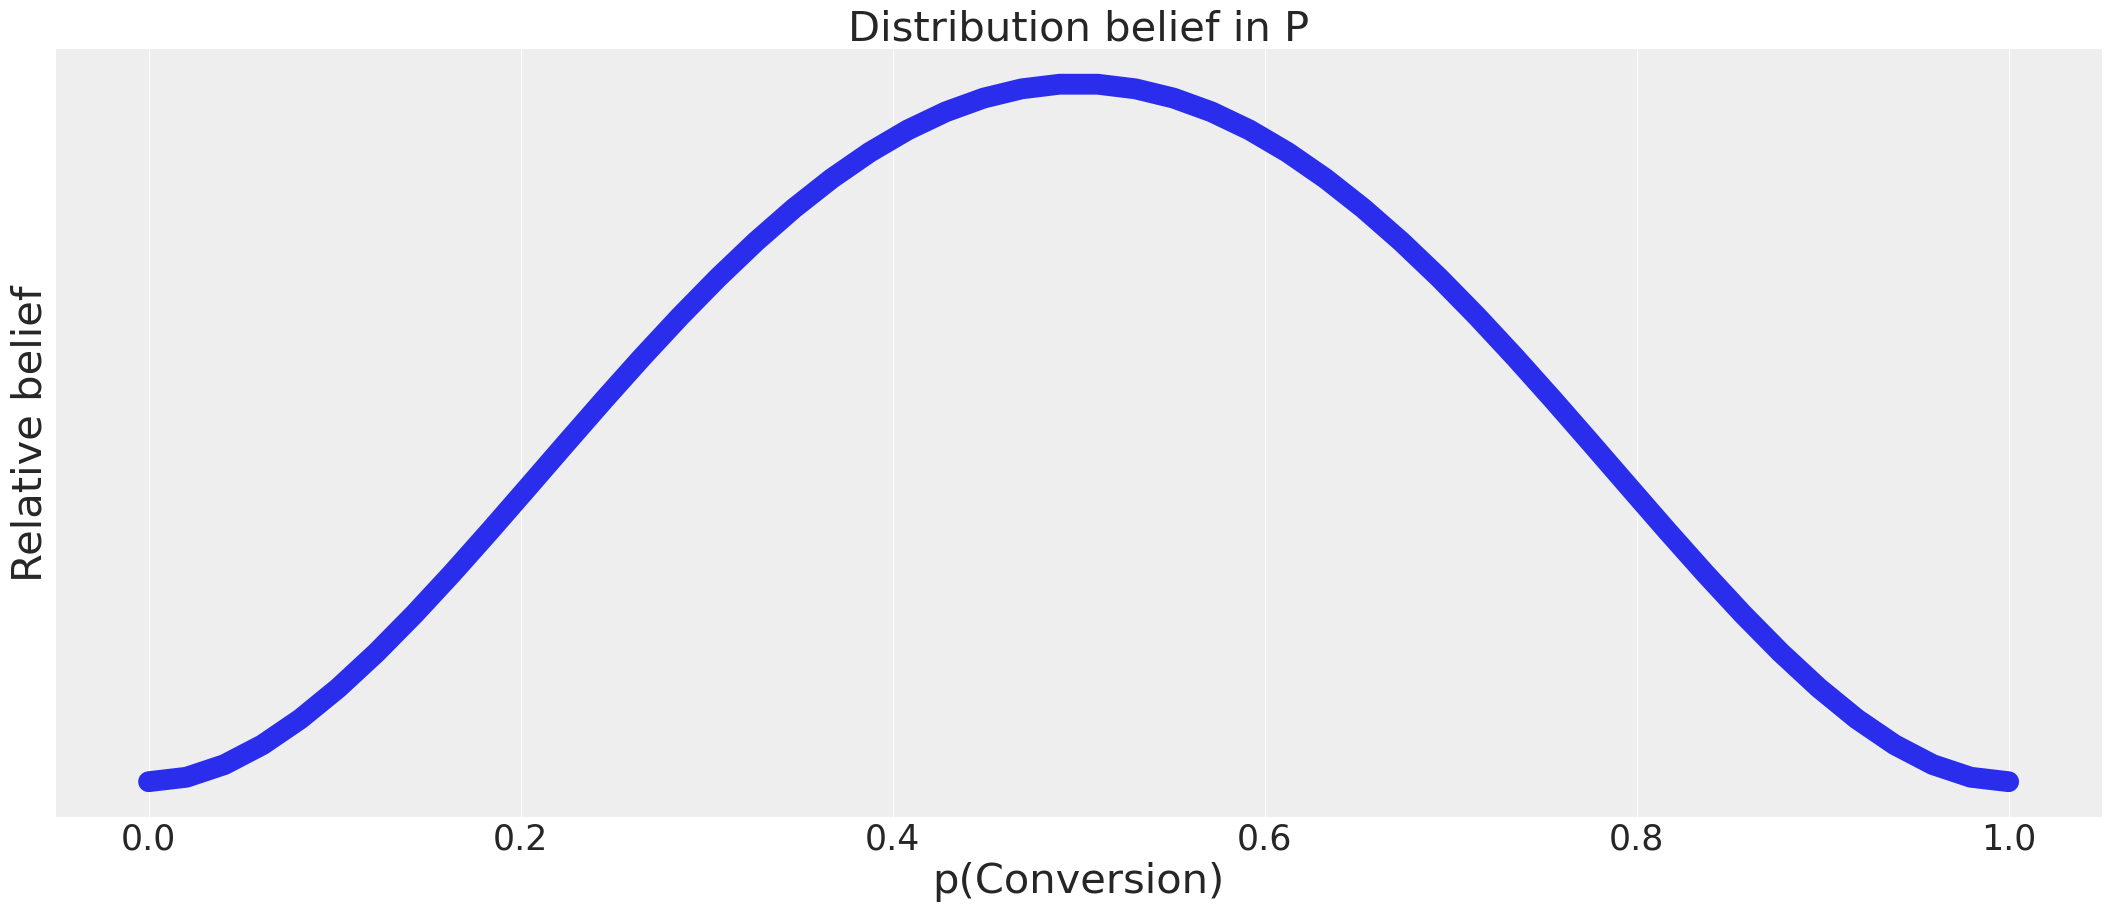

In [11]:
beta_dist = stats.beta(3, 3)
x = np.linspace(0, 1)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)


To communicate uncertainty we can distribution. The distribution conveys our belief in *every possible conversion value*. This is the key idea in Bayesian statistics.

The x axis is every possible value of the *probability of conversion* and the blue line is our relative belief in each value.

## Another possible belief distribution for conversion
The shape and domain of the distribution conveys our belief. Now how this one is different and much more concentrated around 10%

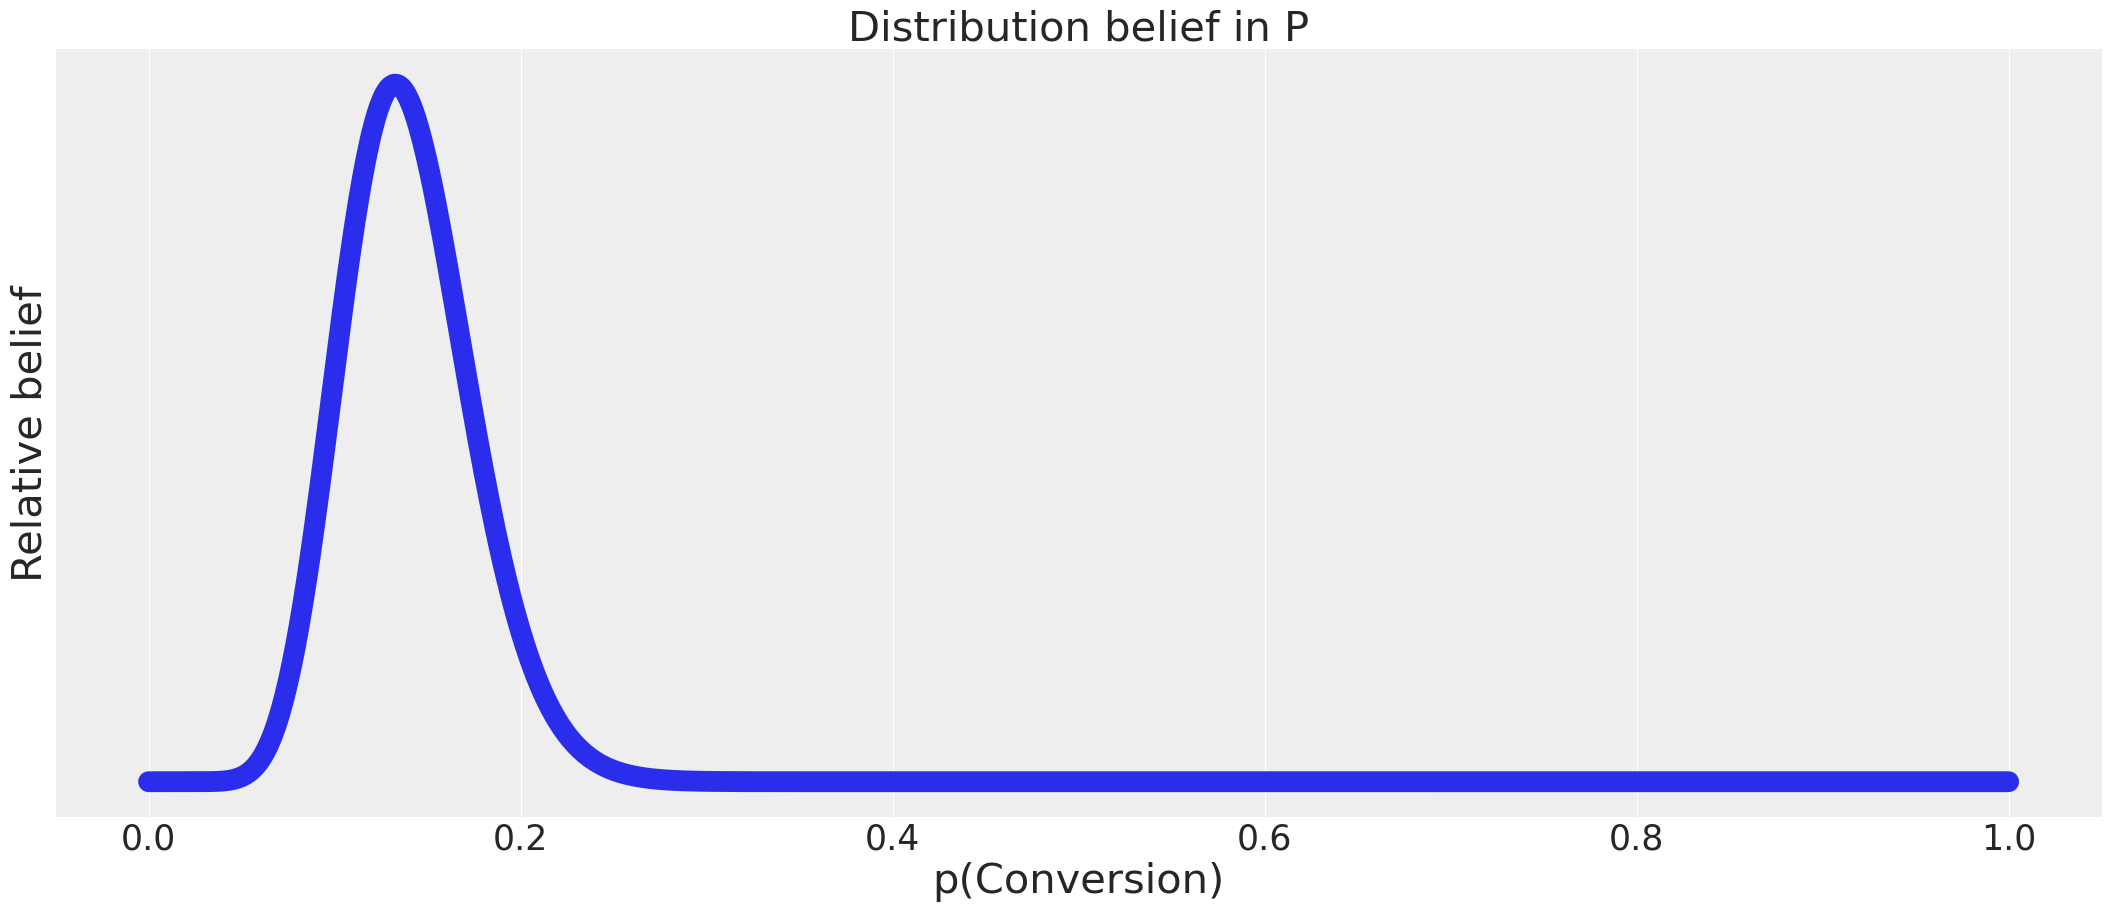

In [12]:
beta_dist = stats.beta(14, 86)
x = np.linspace(0, 1, 1000)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

## Distributions are not just for probabilities but observations too
Lets say we observe the heights of the people below

In [93]:
heights = [190, 191, 195, 192, 193, 200, 205, 210]

/tmp/ipykernel_30036/280653560.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(i,np.max(y)*.02 ,'ro', c='b', label="Observed Values" if i == 190 else "")


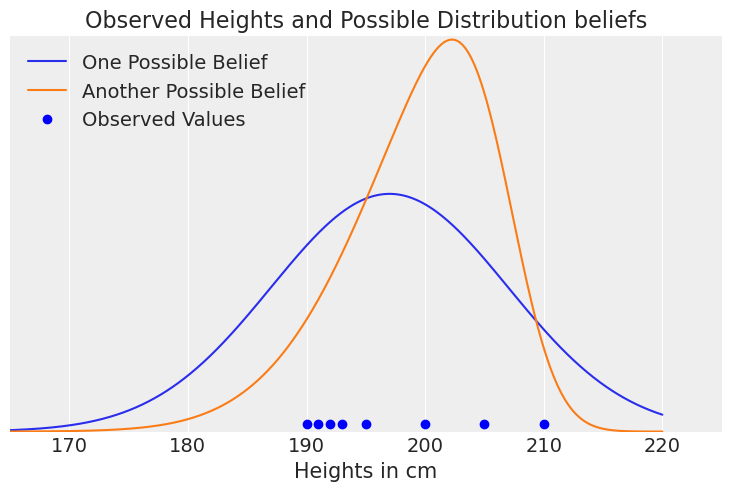

In [96]:
fig, ax = plt.subplots()
y = 0


ax.set_title("Observed Heights and Possible Distribution beliefs")

x = np.linspace(160, 220, 1000)
y = stats.norm(np.mean(heights), 10).pdf(x)
ax.plot(x,y, label="One Possible Belief")

y = stats.skewnorm(loc=np.mean(heights)+10, scale=10, a=-3).pdf(x)
ax.plot(x,y, label="Another Possible Belief")


for i in heights:
    ax.plot(i,np.max(y)*.02 ,'ro', c='b', label="Observed Values" if i == 190 else "")

ax.set_ylim(0, np.max(y)*(1+.01))
ax.set_xlim(165, 225)
plt.legend()

ax.set_xlabel("Heights in cm")
ax.set_yticks([]);


Distributions aren't just limited to our belief in unobserved concepts like p conversion, but also to observed measurements, like the height of people.

Lets say we observed the height of folks in centimeters, we can convey our belief in the height of all people using distributions as well

# Why Bayes is the best



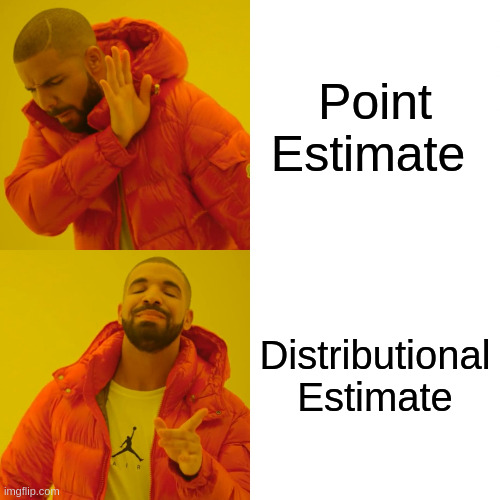

We don't just get *one* value we believe *every* value and can precisely describe by how much.

This distributional belief system is a key differentiator of Bayesian approaches versus most other machine learning methods and also enables some really cool capabilities you're going to see in this lesson and the next.

## Section Recap
* Distributions convey more information than point estimates. In particular
  * The range of our uncertainty
  * The value of that uncertainty

# What are distributions?
How they're defined and how you can define them

## They're necessarily Bayesian
*Insert image of bayes crossed out

Distributions at their purest form as just mathematical functions 

$$ \Large
\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, x^{\alpha-1}(1-x)^{\beta-1} 
$$
This theoretical definition is important for proofs and such.

However in this course we will be specifying distributions with code. This will allow us to use distributions for computation as you'll see throughout this course.

You may have gotten the idea by now that using distributions means you're Bayesian. Let's clear this up now. While Bayes theorem is built from distributions, it itself is not Bayesian.

Think of it like a brick. A brick isn't a house, but it can be used to build one.

## Mathematically defined


$$ \Large
\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, x^{\alpha-1}(1-x)^{\beta-1} 
$$


Distributions at their purest form as just mathematical functions of one sort of the other. They take in values and output values.

Now these functions are specifically defined, and their outputs mean something specific but we'll get to that in the next section.


## In this course distributions are code
In computational statistics distributions are objects in code

In [ ]:
norm = stats.norm(0,1)

with pm.Model():
    beta = pm.Beta("Beta_dist", 1,1)

Before I scare you too much with math, know in this course distributions will be code, as you've already seen. 

By using available code library we'll be able to both skip a bunch of the algebra headache and simultaneously take advantage of computation to do some really neat stuff.

Before we get to that though let's talk about how to fully define a distributions

##  How to fully specify a distribution
Two parts
* The distribution type
* The specific parameterization

Recall our A/B test example, we need a way to represent the probability of conversion.

Beta is a great choice because it's bounded from 0 to 1, just like probability.

# A possible  p(conversion) distribution
One possible distribution is the one below, but *why* is this distribution the shape it is? And why is bounded from 0 to 1?

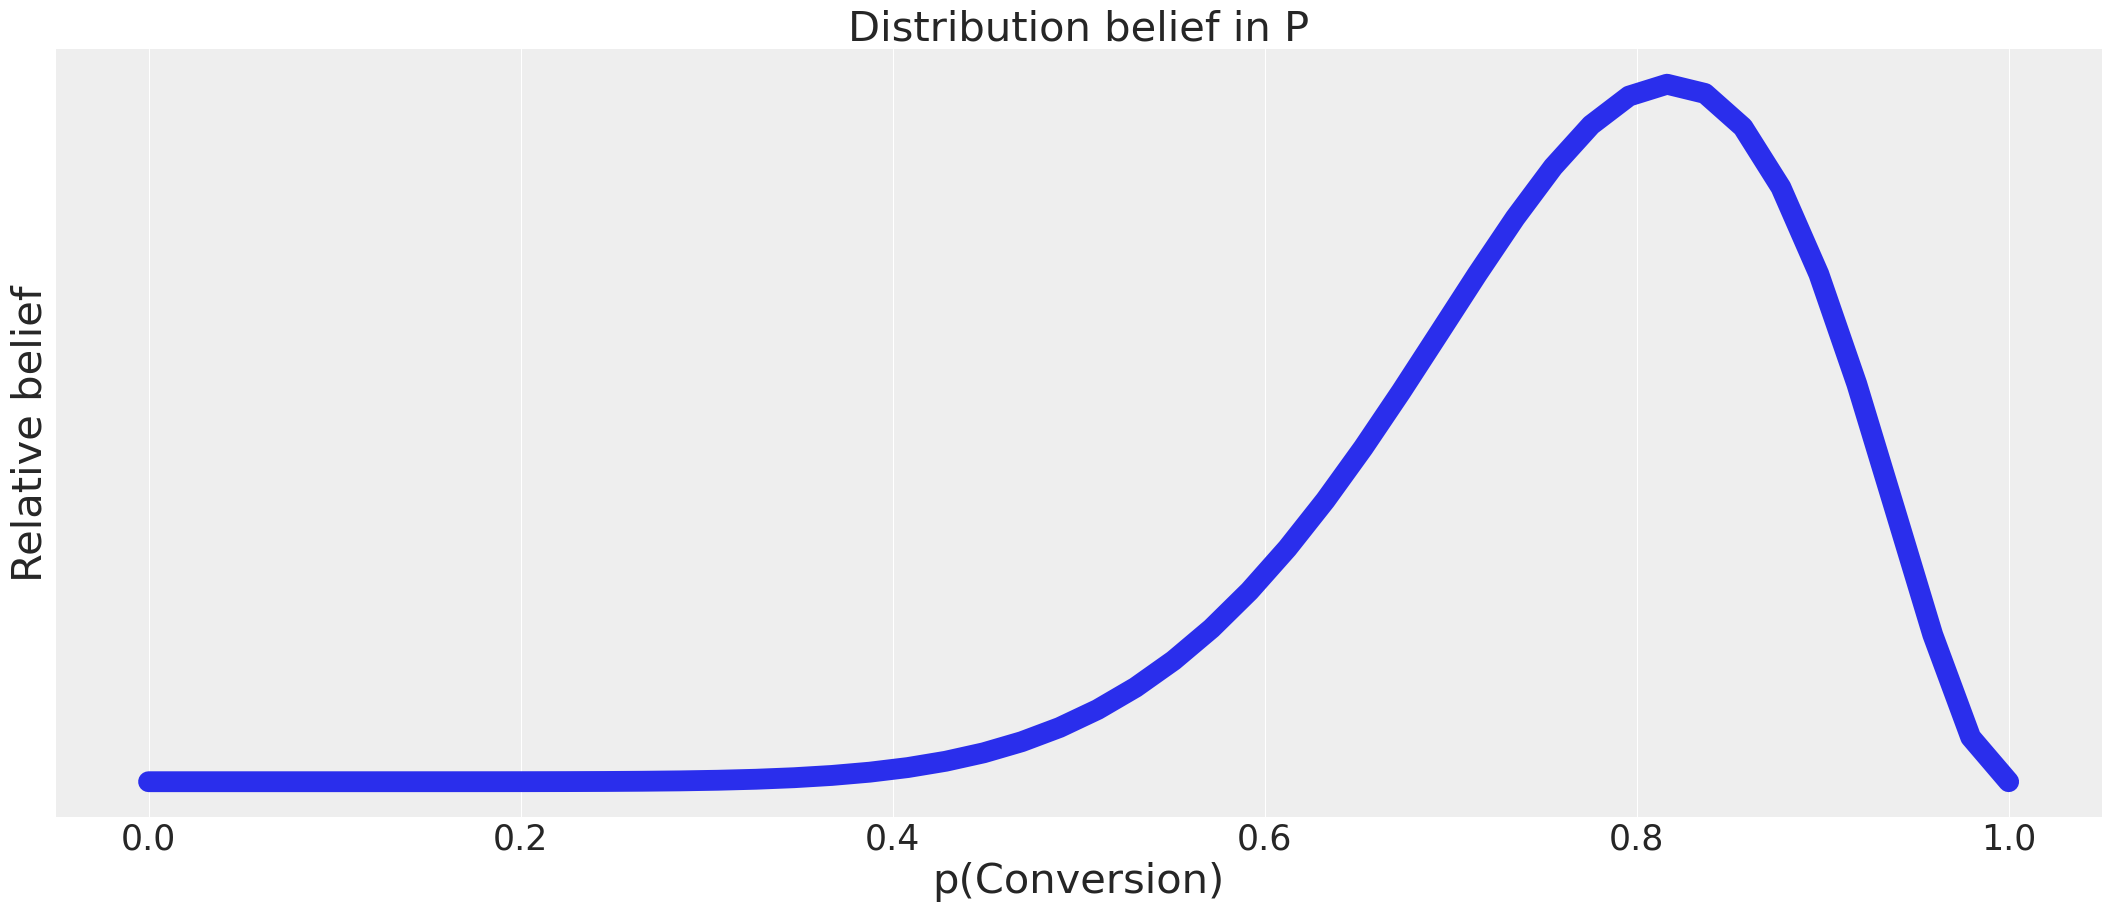

In [3]:
beta_dist = stats.beta(10, 3)
x = np.linspace(0, 1)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)


# Distribution choice and parameters
It's because we chose both a *Beta* distribution and its *parameters*

The choice of Beta distributions bounds possible values to the domain of (0,1)  
The choice of parameters is what specifies the shape of the Beta distribution

In this case the fully specified distribution is a *Beta(10, 3)*

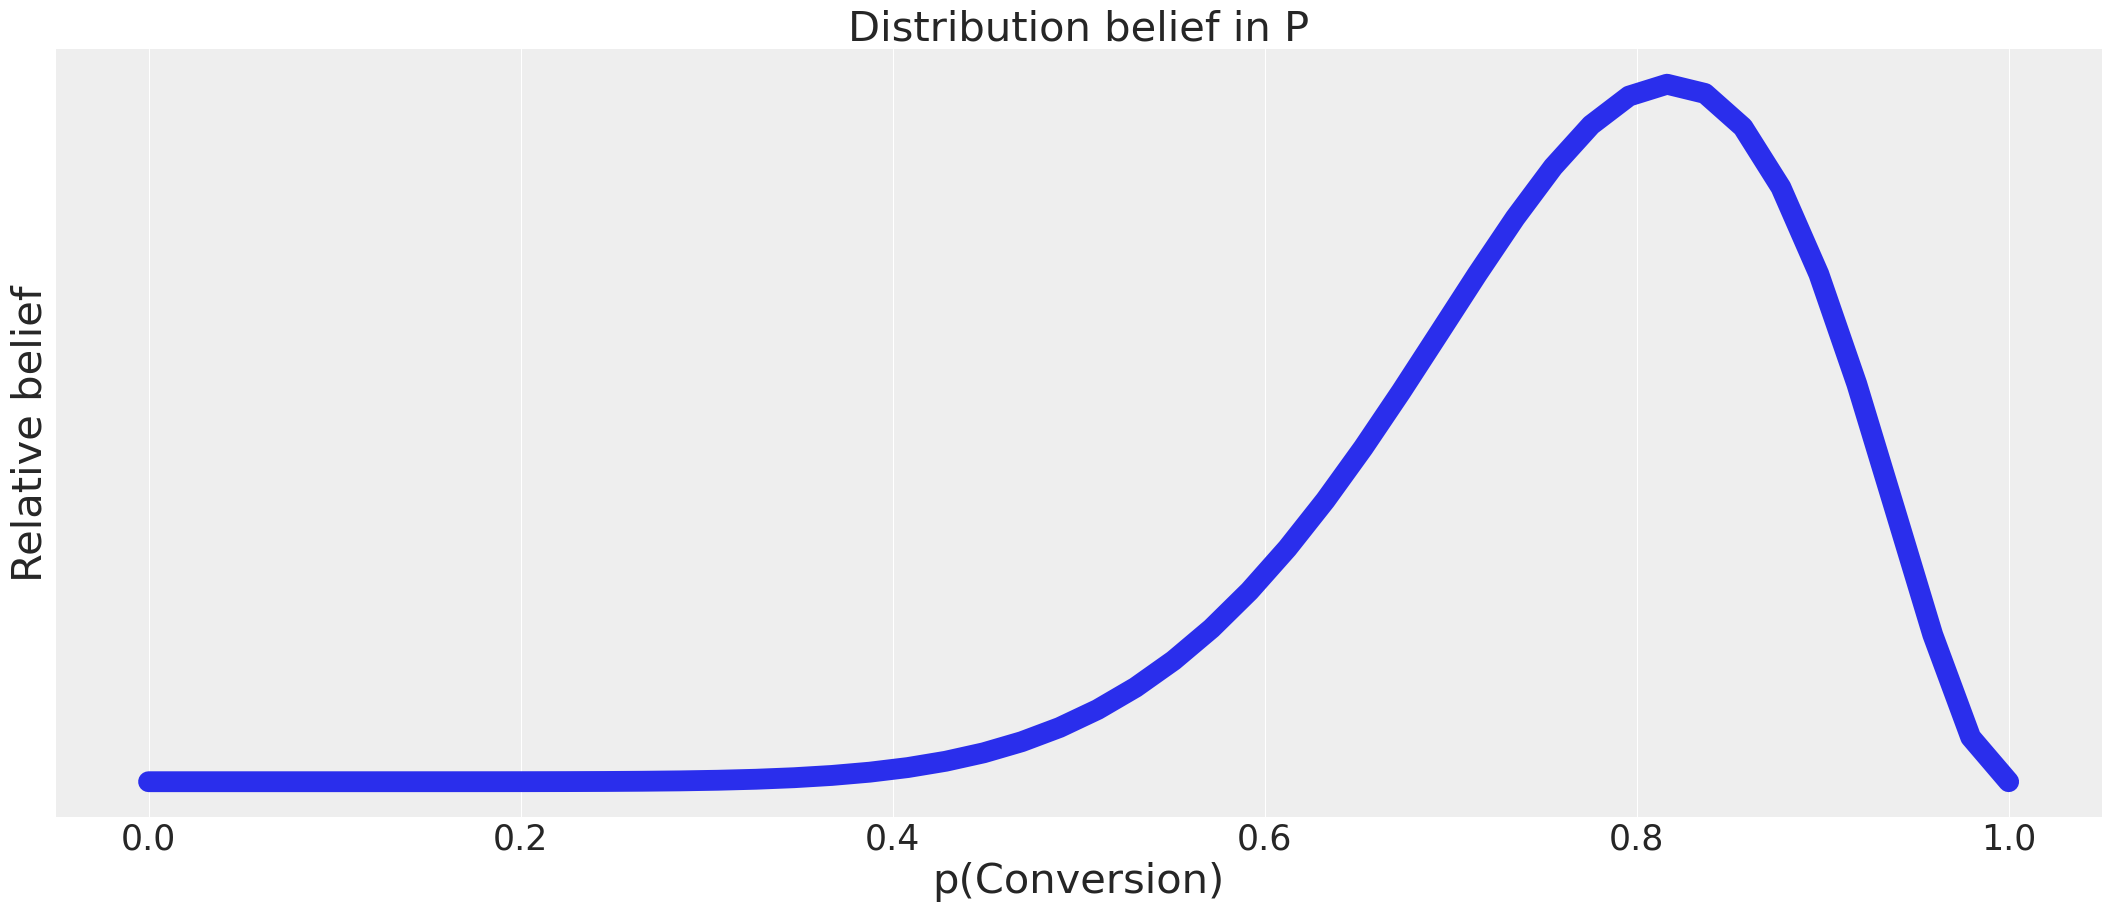

In [4]:
beta_dist = stats.beta(10, 3)
x = np.linspace(0, 1)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

## Defined by type and parameters

# Other choices of distribution parameters
Below are three distributions with different parameterizations. 

They all have different shapes based on the different parameters used to specify each, even though all are *beta* distributions

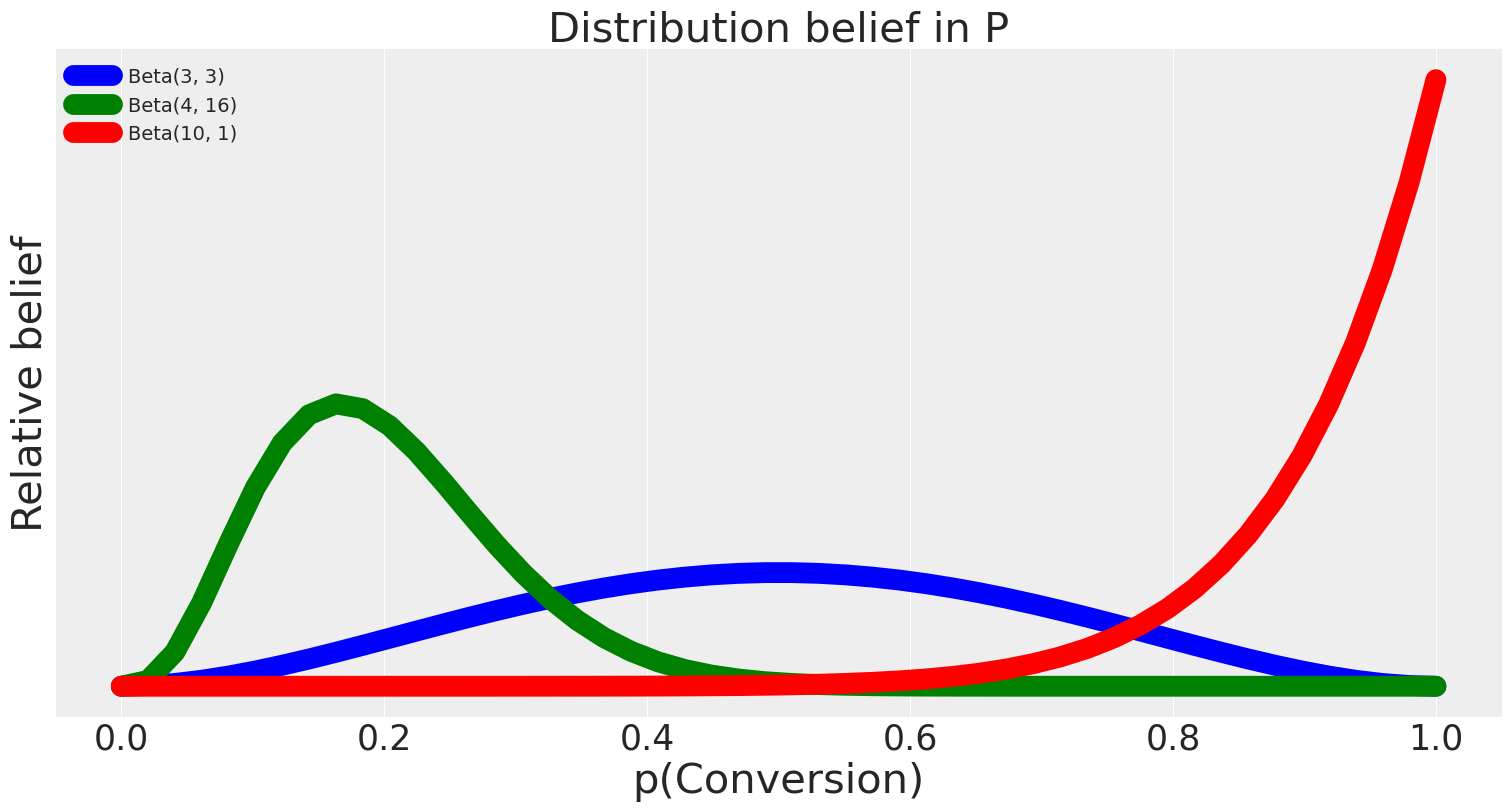

In [5]:
fig, ax = plt.subplots(figsize=(15,8))

for i, (a, b, c) in enumerate(((3,3,'blue'), (4,16,'green'), (10,1,'red'))):

    beta_dist = stats.beta(a, b)
    x = np.linspace(0, 1)
    y = beta_dist.pdf(x)
    ax.plot(x,y, linewidth=15, c=c, label=f"Beta({a}, {b})")

    ax.set_yticks([])
    ax.set_title("Distribution belief in P", fontsize=30)
    ax.set_xlabel("p(Conversion)", fontsize=30)
    ax.set_ylabel("Relative belief", fontsize=30)
    ax.tick_params(axis='x', labelsize=25)

ax.legend()

# Distributions as code, instead of math

Distributions have traditionally been specified with mathematical notional such as the one below. 

$$ \Large
\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\, x^{\alpha-1}(1-x)^{\beta-1} 
$$
This theoretical definition is important for proofs and such.

However in this course we will be specifying distributions with code. This will allow us to use distributions for computation as you'll see throughout this course.

In [6]:
beta_1 = scipy.stats.beta(a=1, b=2)

# Unfortunately notation and naming is not always consistent


In [7]:
# Greek Symbols
μ = 0
σ = 1
norm_1 = stats.norm(μ, σ)

In [8]:
# Phonetic Names
mu = 0
sigma =1
norm_1 = pd.norm.dist(mu=mu, sigma=sigma)

In [10]:
# Intuitive Names
norm_1 = stats.norm(loc=0, scale=1)

And in other cases they are parameterized by intuitive names, such as "loc" short for location, or "scale"

Distributions are used by a wide variety of people across a wide variety of fields. The wide applicability is a great, but what is not is the subtle inconsistencies.

Mathematically identical distributions can be parameterized using different symbols depending on who wrote the code or library, even if the underlying distribution is the same.

For example, more mathematical authors will use Greek symbols

While we wish the world was standardized it unfortunately is not the case. Refer to the documentation of each library used to double check what you intend to specify is indeed what the library is expecting.

The good news is after some time you'll be able to read all forms of notation equally well.

# Section Recap
* Distributions are
  * Defined by math 
  * Implemented in code
* Two things are needed to fully specify a distribution
    * The specific distribution itself
    * The parameters for that distribution
* Distribution parameterization naming is not consistent across libraries and sources
  * Use references often when starting out to get things right

# Probability Mass and Density Functions

How to precisely determine our relative belief in each value

Now we know why: To convey uncertainty
We know what: 

How: PMF and PDF

# Revisiting our beta p(conversion) for our A/B test
We've discussed how 
1. We want describe our possible set of beliefs of the conversion rate p(conversion)
2. We can use a Beta distribution for this purpose
3. We can specify the parameter of our Beta function to be Beta(4,8) to highlight a specific belief

What we have not shown yet is how we precisely measure the specific belief. Let's talk through it

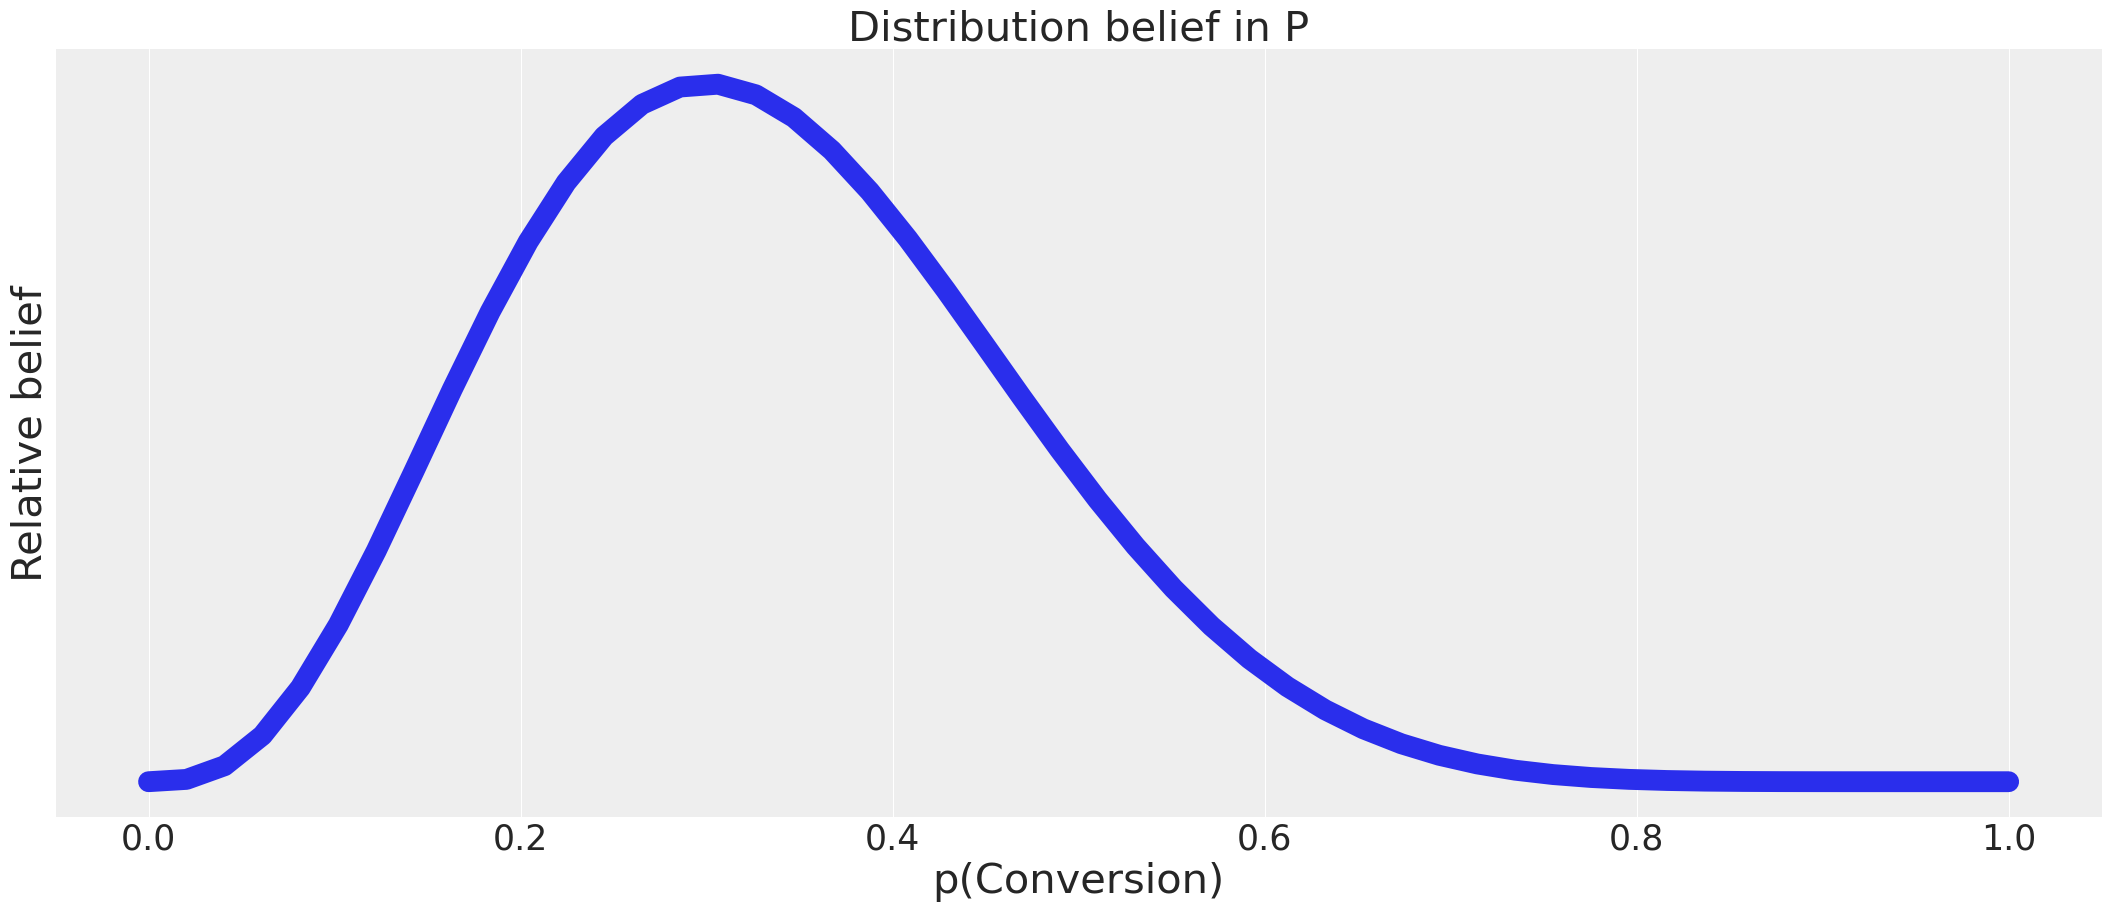

In [3]:
beta_dist = stats.beta(4, 8)
x = np.linspace(0, 1)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

# P value of one person converting
When someone visits our website they either *convert* or *don't convert*  
Let's assume the probability of one person converting is precisely **30%**, or .3  
We can use a *Bernoulli* distribution to model this situation

A Bernoulli distribution only requires one parameter, p, to fully specify

In [4]:
p = 0.3
bern = stats.bernoulli(p)

# Introduction to Probability Mass Function

Now that we've defined a probability distribution computationally we can use it to determine the amount of *mass* associated with the potential outcomes 0 and 1 using the `.pmf` method

In [5]:
bern.pmf(0), bern.pmf(1)

(0.7, 0.3)

1 represents *conversion*, and 0 represents *didn't convert*

# We can plot the probability mass function too
The vertical height represents the proportion of mass associated with each outcome 0 and 1. 

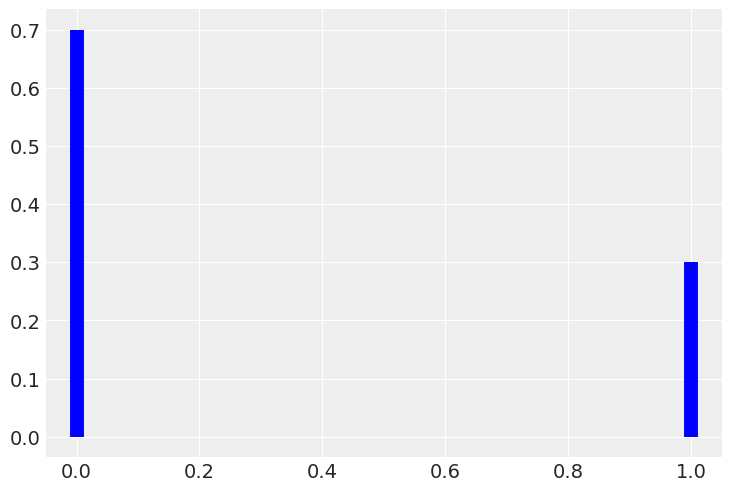

In [6]:
fig, ax = plt.subplots()
potential_outcomes = np.arange(2)
ax.vlines(potential_outcomes, 0, bern.pmf(potential_outcomes), colors='b', linestyles='-', lw=10);

Right now you may be thinking Well "duh", that was obvious. We didn't a computer to tell us that. Let's work through a more complicated case.

# Introducing the Binomial distribution
What if we now are interested in the probability of number of conversions in a group of 10 people.

In this case there are two parameters are needed to specify the distribution,
* *p* the probability of success on an individual trial 
* *n* the number of trials. 

# Calculating a probability for a single random outcome
What is the chance 4 people convert out of 10, if the probability of conversion is .3?

In [7]:
binom = stats.binom(n=10, p=.3)

number_of_conversions = 4
binom.pmf(number_of_conversions)

0.2001209489999999

The probability mass function here is telling us that 20% of the *mass* of the distribution is associated with the outcome *4 people convert*

If we instead want to know the probability that 7 people convert we can plug that number in as well, and intuitively the mass is lower. With a 30% probability of conversion we would expect 7 conversion to be *less likely* than 4 conversions.

In [8]:
number_of_conversions = 7
binom.pmf(number_of_conversions)

0.009001691999999992

# Plotting a binomial probability mass function
Because we defined things computationally we can use our handy plotting tools to visualize the probability mass function.

As we would expect 3 people converted is the most likely.

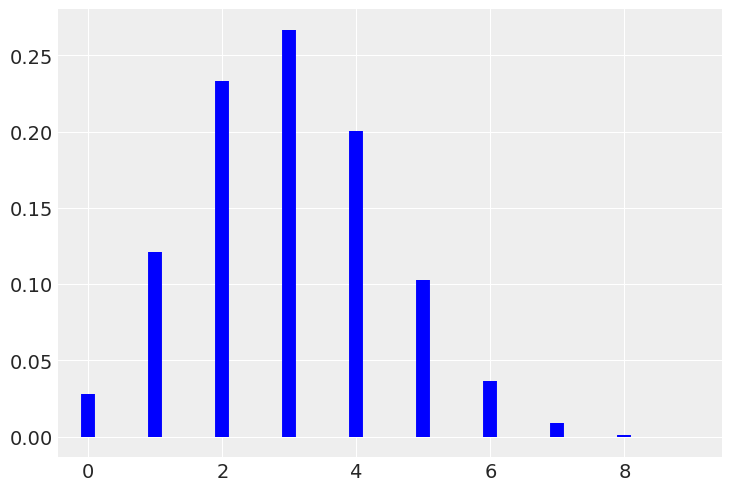

In [9]:
fig, ax = plt.subplots()
potential_outcomes = np.arange(10)
ax.vlines(potential_outcomes, 0, binom.pmf(potential_outcomes), colors='b', linestyles='-', lw=10);

# Discrete distributions versus Continuous distributions
The Bernoulli and Binomial distributions are known as *discrete* outcomes. That's because they measure outcomes that are in a fixed set. 

In a Bernoulli distribution that set is 2, either the person converted or they didn't. In our Binomial example the set is 11, 0 to 10 people can convert.

But what continuous outcomes, like our Beta distribution for p(conversion)?

# Probability Density Function

With continuous distributions we can precisely compare different values  using a probability *density* function.

In [14]:
beta_dist = stats.beta(4, 8)
beta_dist.pdf(.3233243)

2.898364724572644

But what does this number mean exactly?

# Relative value is what matters in PDFs
PDFs take in a value, and output the relative *likelihood* of that value occurring given a distribution.

In [11]:
 beta_dist.pdf(.3), beta_dist.pdf(.5)

(2.9351072519999977, 1.2890625)

The numbers here are telling us that probability value of conversion of 30% is more likely than one of 50% given our distribution.

# Visual representation of PDF and relative heights
The red lines represent the PDF value of 30% and 50%

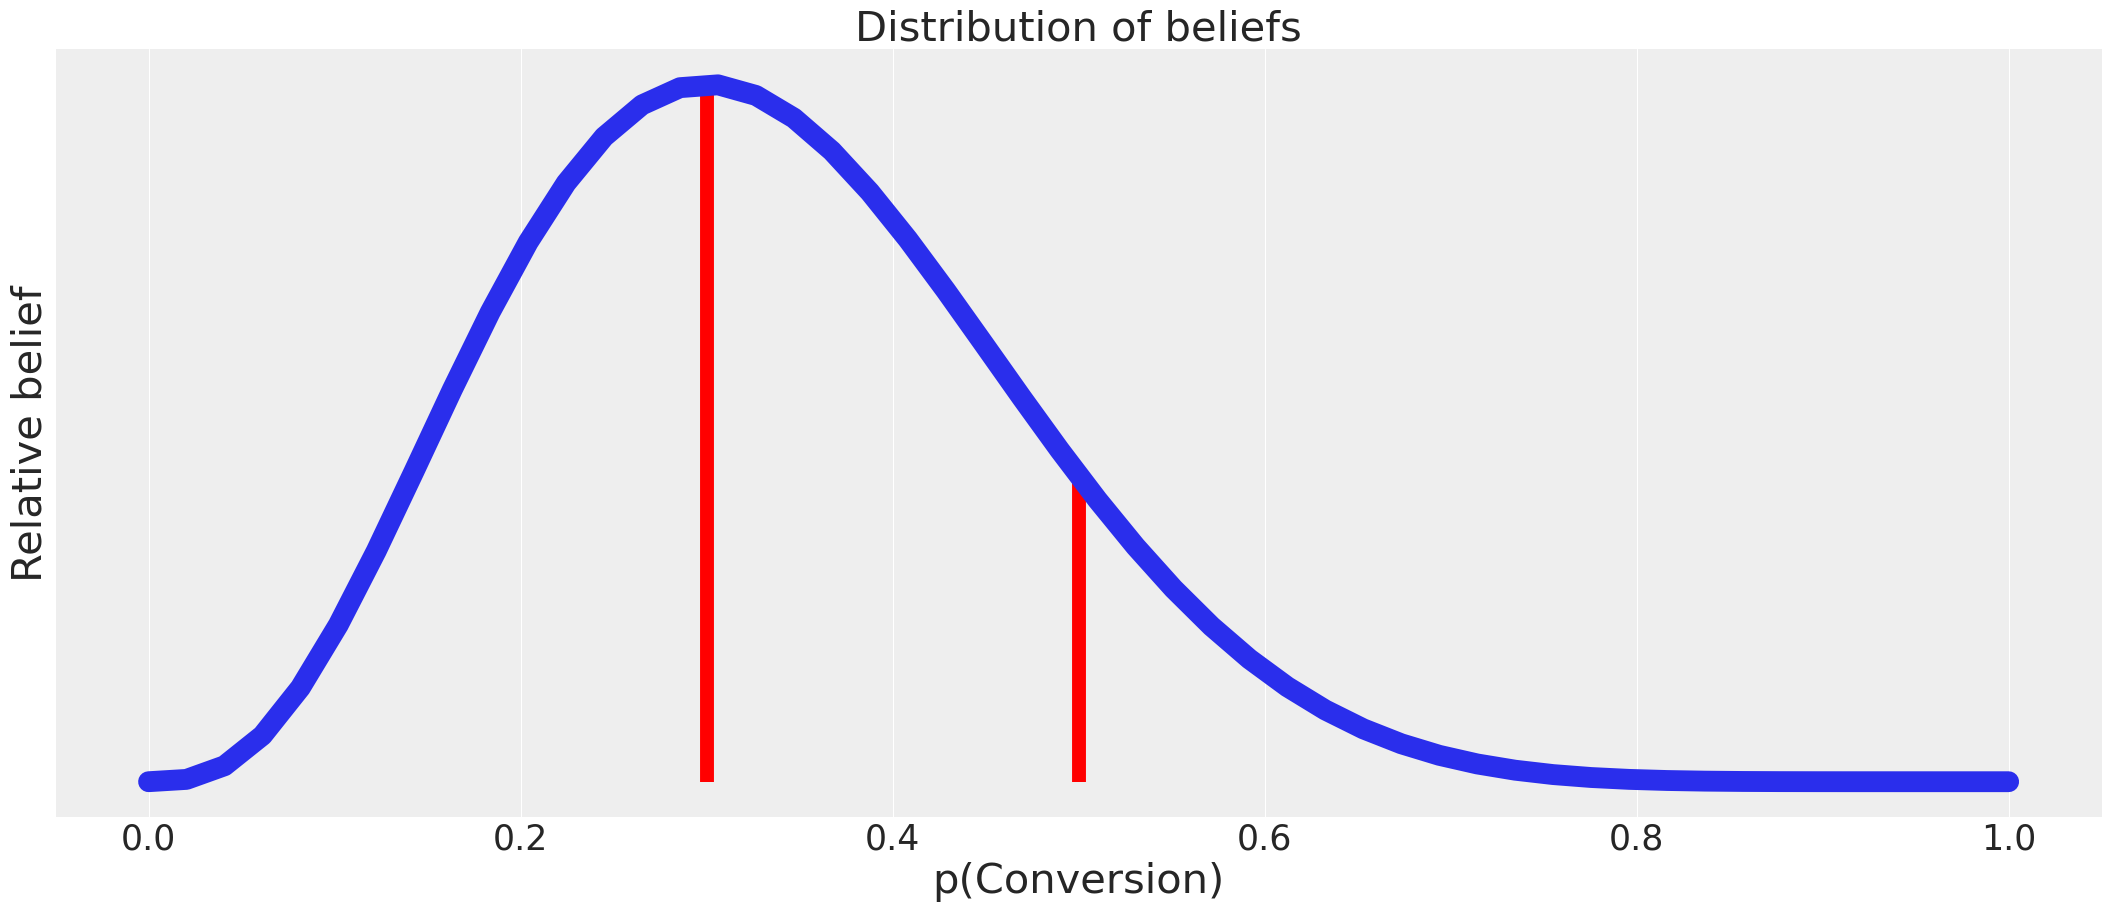

In [12]:
x = np.linspace(0, 1)
y = beta_dist.pdf(x)

fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)
ax.set_yticks([])
ax.set_title("Distribution of beliefs", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)
markerline, stemline, baseline = ax.stem(.3, beta_dist.pdf(.3), "r")
plt.setp(stemline, linewidth = 10)

markerline, stemline, baseline = ax.stem(.5, beta_dist.pdf(.5), "r")
plt.setp(stemline, linewidth = 10);

By checking this plot its much easier to see the relative likelihood of the two p values

# PDF is not probability
The probability of any single number in a continuous distribution is **0**,

This is because of the foundational way mathematical measure theory works. In a continuous distribution any single number is infinitely small so it can't have mass. We can get the probability for a *range* of numbers but that's not important for this course.

# What is LogPDF
Its just the PDF value but transformed into the log scale **just for computational reasons**



In [15]:
np.log(beta_dist.pdf(.3)), beta_dist.logpdf(.3)

(1.0767439950314812, 1.0767439950314817)

This is done for purely computational stability reasons. Again this is a computational detail that is not important to understand up front. We bring this up as you may hear the term LogPDF and don't want it to surprise you.

So be aware you may see the the terms PDF, and LogPDF. Just translate that in your head as "a thing that gives me relative likelihoods of seeing a certain value"

# Section Recap
* For every possible outcome or belief PMF and PDF tells us the relative likelihood  of that value, versus any other value 
* LogPDF the same concept
  * just with a mathematical transform applied
  * just for computational reasons


# Two Types of Samples
Observed and computational samples

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy
from scipy import stats

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [3]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# A/B test observations
In our A/B test we showed 100 people website B. Those 100 people are a population sample, meaning they are meant to represent 100 people from the larger group of people that could visit website B sometime in the future.

Importantly these are also samples *we observed*

# Diagram of Population Samples
These are samples from a "real world" population. Population samples are the samples you typically read about in statistics textbooks.


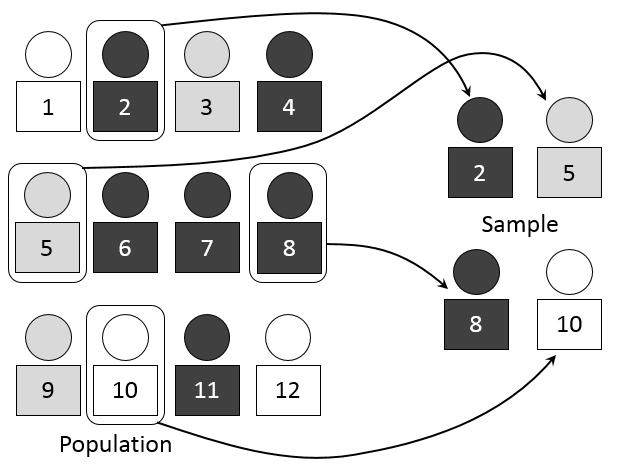
https://en.wikipedia.org/wiki/Sample_(statistics)

### Other Examples
* Calling 10 people to ask who they'll vote for
* Testing a new drug in a treatment trial on 10 people
* Collecting 10 vials of water from 10 lakes to measure toxins

# (Computational) Distribution Samples
The other related concept is taking random values from a computational distribution. These samples are not something that we've observed or counted. They purely are random draws from a computer.

For example we can define a Bernoulli distribution computationally and take 10000 samples

In [4]:
# Lets draw a 10000 random samples and see what we get
p = 0.3
bern = stats.bernoulli(p)

num_samples = 100000
samples = bern.rvs(num_samples)

samples[:10], samples.mean()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.29896)

These samples are not of any population we've observed. It's purely us defining a distribution in a computer and values from that distribution that are generated at random.

# Samples from a Normal distribution
Let's do the same thing again but with  Normal distributions. Here's an example of 10 random draws

In [5]:
unit_norm = stats.norm(0,1)
unit_norm.rvs(10)

array([-0.25293481,  0.11360463, -0.93556677, -0.71761125, -1.62652358,
       -2.04761405, -0.40536258,  0.01611607,  0.36329753, -1.63225689])

If we computationally generate 100,000 samples we unsurprisingly end up with a unit normal distribution centered on 0 with standard deviation 1.

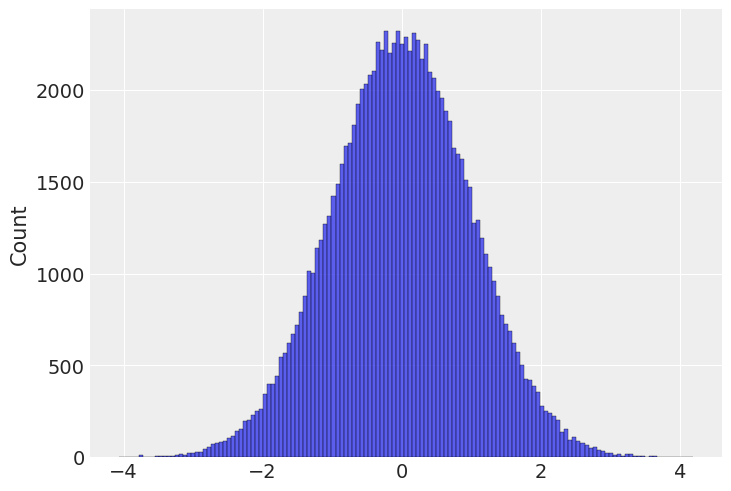

In [6]:
sns.histplot(unit_norm.rvs(100000));

# But why do this?
If we already know the distribution we're sampling from why are we taking samples? What's even the point

*When don't know the true distribution by taking samples in a clever way we can estimate it*

# Sampling is the foundation of Monte Carlo algorithms (and this course)
Markov Chain Monte Carlo is one of the most popular ways of effectively utilizing Bayes Theorem in practice.
It relies entirely on taking samples in clever ways, and the information from those samples is what enables all inferential magic we're looking for.

Computers made this all possible which is why you're seeing such an explosion of Bayes usage today

If this doesn't make sense don't worry too much right now. It'll be covered in other lessons

# Observed and Computational Sampling work together
Clever use of both *observed* samples, coupled with *computational sampling* is how we make estimates of the world and perform *inference*.

Again if this doesn't make sense now don't worry, it will become very evident in future lessons.

# Section Recap
* There are two kinds of samples we'll be using in this course.
    * Observed data, which is samples from the "real world"
    * Computational samples, which are samples from computationally defined distributions
* Computational sampling is the foundation for Monte Carlo algorithms
    * Notably Markov Chain Monte Carlo, the algorithm that makes Bayesian methods so accessible 
* Using population and computational samples together is what enables *inference* 
